In [1]:
import sys , time
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output

from libs.utilities import get_freer_gpu
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [2]:
start_time = time.time()

### Parameters

All parameters are from https://www.sciencedirect.com/science/article/pii/S0031320319303863?casa_token=nQ0EemyP9jgAAAAA:HJrhjp_JUm8rFhyJO78IoKJj9gVLAFzTsFOkC0iBfbywM2Myihk_W-F4lJ45dHYklsuuo8VHVwdl

In [3]:
dataroot = "six_objects_1000stimuli/"
num_epochs_alex = 5
num_epochs = 20
workers = 4
batch_size = 512
image_size = 64
num_channel = 3 
z_dim = 100
gen_dim = 64
dis_dim = 64
ngpu = 2
lr = 1e-4
lambda_gp = 10
num_classes = 6
embed_size = 100 #<---follow the paper
feature_size = 200

### Load dataset

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),  
                               transforms.Normalize([0.5 for _ in range(num_channel)], [0.5 for _ in range(num_channel)]), 
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Device = ", device)

real_batch = next(iter(dataloader))

print("Min (should be -1): ", real_batch[0].min())
print("Max (should be 1): ", real_batch[0].max())
print("X shape: (batch, C, H, W)  ", real_batch[0].shape)
print("Label shape: (batch)  ", real_batch[1].shape)
print("Label unique values: (batch)  ", real_batch[1].unique())

# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Device =  cuda:0
Min (should be -1):  tensor(-1.)
Max (should be 1):  tensor(1.)
X shape: (batch, C, H, W)   torch.Size([512, 3, 64, 64])
Label shape: (batch)   torch.Size([512])
Label unique values: (batch)   tensor([0, 1, 2, 3, 4, 5])


### Weight Initialization

In [5]:
# custom weights initialization called on netG and netD
def weights_init(model):
    for m in model.modules(): #loop all layers in that model
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

### Image Extractor

In [6]:
class SemanticImageExtractor(nn.Module):
    """
    This class expected image as input with size (64x64x3)
    """
    def __init__(self, ngpu, pretrain=False):
        self.ngpu = ngpu
        super(SemanticImageExtractor, self).__init__()
        self.features = nn.Sequential(
            # Alex1
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Alex2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Alex3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            # Alex4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            # Alex5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # return the same number of features but change width and height of img
        if(pretrain):
            import torchvision
            ori_alex = torchvision.models.alexnet(pretrained = True)
            ori_weight = ori_alex.state_dict()
            ori_weight.pop('classifier.1.weight')
            ori_weight.pop('classifier.1.bias')
            ori_weight.pop('classifier.4.weight')
            ori_weight.pop('classifier.4.bias')
            ori_weight.pop('classifier.6.weight')
            ori_weight.pop('classifier.6.bias')
            self.load_state_dict(ori_weight)
            del(ori_alex)
            del(ori_weight)
        # finally
        self._add_classifier(num_classes, feature_size)
    def _add_classifier(self, num_classes, feature_size):
        self.fc06 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU()
        )
        self.fc07 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, feature_size),
            nn.ReLU()
        )
        self.fc08 = nn.Sequential(
            nn.Linear(feature_size, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc06(x)
        semantic_features = self.fc07(x)
        p_label = self.fc08(semantic_features)
        return semantic_features, p_label

### Generator

In [7]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #Input: batch x z_dim x 1 x 1 (see definition of noise in below code)
            self._block(z_dim + embed_size + feature_size, gen_dim * 16, 4, 1, 0),  #batch x 1024 x 4 x 4
            self._block(gen_dim * 16, gen_dim * 8, 4, 2, 1),  #batch x 512 x 8 x 8
            self._block(gen_dim * 8, gen_dim * 4, 4, 2, 1),  #batch x 256 x 16 x 16
            self._block(gen_dim * 4, gen_dim * 2, 4, 2, 1),  #batch x 128 x 32 x 32
            nn.ConvTranspose2d(
                gen_dim * 2, num_channel, kernel_size = 4, stride = 2, padding =1,  #did not use block because the last layer won't use batch norm or relu
            ),  #batch x 3 x 64 x 64
            nn.Tanh(), #squeeze output to [-1, 1]; easier to converge.  also will match to our normalize(0.5....) images  
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,kernel_size,stride,padding,bias=False,  #batch norm does not require bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True) #in_place = True
        )
    
    def forward(self, x, labels, semantic_latent):
        #semantic latent: batch, feature_size
        #Input: latent vector z: batch x z_dim x 1 x 1
        #in order to concat labels with the latent vector, we have to create two more dimensions of 1 by unsqueezing
        semantic_latent = semantic_latent.unsqueeze(2).unsqueeze(3) #batch, feature_size, 1, 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3) #batch, embed_size, 1, 1
        x = torch.cat([x, embedding, semantic_latent], dim=1)
        return self.net(x)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (net): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(400, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0

### Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #no batch norm in the first layer 
            #Input: batch x num_channel x 64 x 64
            #<-----changed num_channel + 1 since we add the labels
            nn.Conv2d(
                num_channel + 1 + 1, dis_dim, kernel_size=4, stride=2, padding=1,
            ), #batch x 64 x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            self._block(dis_dim, dis_dim * 2, 4, 2, 1), #batch x 128 x 16 x 16
            self._block(dis_dim * 2, dis_dim * 4, 4, 2, 1), #batch x 256 x 8 x 8
            self._block(dis_dim * 4, dis_dim * 8, 4, 2, 1), #batch x 512 x 4  x 4
            nn.Conv2d(dis_dim * 8, 1, kernel_size=4, stride=2, padding=0), #batch x 1 x 1 x 1 for classification
#             nn.Sigmoid(), #<------removed!
        )
        self.embed = nn.Embedding(num_classes, image_size*image_size)
        self.linear = nn.Linear(feature_size, image_size*image_size)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,  #batch norm does not require bias
            ),
            nn.InstanceNorm2d(out_channels, affine=True), #<----changed here
            nn.LeakyReLU(0.2, True) #slope = 0.2, in_place = True
        )

    def forward(self, x, labels, semantic_latent):
        #Label after embed shape: batch, image_size * image_size
        #reshape the labels further to be of shape (batch, 1, H, W) so we can concat
        #embedding shape:  batch, 1, image_size, image_size
        #semantic latent: batch, feature_size
        embedding = self.embed(labels).view(labels.shape[0], 1, image_size, image_size)
        semantic_embedding = self.linear(semantic_latent).view(semantic_latent.shape[0], 1, image_size, image_size)
        x = torch.cat([x, embedding, semantic_embedding], dim = 1) #batch x (C + 1) x W x H
        return self.net(x)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (net): Sequential(
      (0): Conv2d(5, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (4): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_sl

In [11]:

# Create the image feature extractor
netIE = SemanticImageExtractor(ngpu, True).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netIE = nn.DataParallel(netIE, list(range(ngpu)))

# Print the model
print(netIE)

DataParallel(
  (module): SemanticImageExtractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (fc06): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=9216, out_features=4096,

### Enforces the gradient to be close to 1

In [12]:
def gradient_penalty(dis, labels, real, fake, semantic_latent, device="cpu"): #<---add labels
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate dis scores
    mixed_scores = dis(interpolated_images, labels, semantic_latent)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [13]:
def do_plot( data_dic, title="" ):
    plt.figure(figsize=(15,3))
    for _key, _val in data_dic.items():
        plt.plot( _val , label=_key)
    plt.title(title)
    plt.legend()
    plt.show()

### Training

In [14]:
# Setup Adam optimizers for both G and D
# Use momentum of 0.5 following the paper
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.9))  #<-----changed back! to RMSprop
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0, 0.9))
optimizerIE = optim.SGD(netIE.parameters(), lr=lr, momentum= 0.9)  
criterion = nn.CrossEntropyLoss() 

# Training Loop
img_list = []
G_losses = []
D_losses = []
I_losses = []
iters = 0

E_iter = 2
dis_iter = 1
gen_iter = 1



In [15]:


print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (real, labels) in enumerate(dataloader):  
        real = real.to(device)
        labels = labels.long().to(device)
        cur_batch_size = real.shape[0]
        
        #Train image feature extractor
        for _ in range(E_iter):
            _, alex_pred = netIE(real)
            ie_loss = criterion(alex_pred, labels)

            optimizerIE.zero_grad()
            ie_loss.backward()
            optimizerIE.step()

        #Train D min - (E[dis(real)] - E[dis(fake)])
        for _ in range(dis_iter):
            semantic_latent, alex_pred = netIE(real)
            alex_pred_long = torch.argmax(alex_pred, 1) 
            output_real = netD(real, alex_pred_long, semantic_latent).view(-1)   
            noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
            fake = netG(noise, alex_pred_long, semantic_latent) 
            output_fake = netD(fake, alex_pred_long, semantic_latent).view(-1)
            gp = gradient_penalty(netD, alex_pred_long, real, fake, semantic_latent, device=device) 
            dis_loss = (
                -(torch.mean(output_real) - torch.mean(output_fake)) + lambda_gp * gp
            )
            optimizerD.zero_grad()
            dis_loss.backward()
            optimizerD.step()

        # Train G: min -E[dis(gen_fake)]
        for _ in range(gen_iter):
            semantic_latent, alex_pred = netIE(real)
            alex_pred_long = torch.argmax(alex_pred, 1)
            noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
            fake = netG(noise, alex_pred_long, semantic_latent) 
            output = netD(fake, alex_pred_long, semantic_latent).view(-1) 
            gen_loss = -torch.mean(output)       
            optimizerG.zero_grad()
            gen_loss.backward()
            optimizerG.step()

        # Save Losses for plotting later
        I_losses.append(ie_loss.item())
        G_losses.append(gen_loss.item())
        D_losses.append(dis_loss.item())

        # Check how the generator is doing by saving G's output on noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(noise, alex_pred_long, semantic_latent).detach().cpu() #<---send in noise instead to make sure the label matches
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    clear_output(wait=True)
    sys.stdout.write("\rEpochs: " + str(epoch) + "| Gen Loss: " + str(gen_loss.item()) + "| Dis Loss: " + str(dis_loss.item()) + "| Image Loss: " + str(ie_loss.item()))
    data_plot = { "Gen loss":G_losses, "Dis loss":  D_losses , "Image loss":I_losses } 
    #do_plot( data_plot )

Epochs: 19| Gen Loss: 118.48602294921875| Dis Loss: -96.38084411621094| Image Loss: 0.026040874421596527

### Results

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.

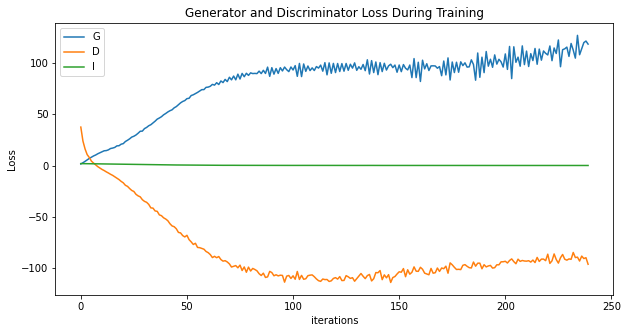

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(I_losses,label="I")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

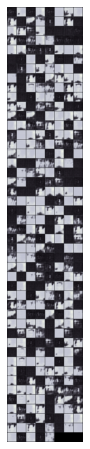

In [17]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side.

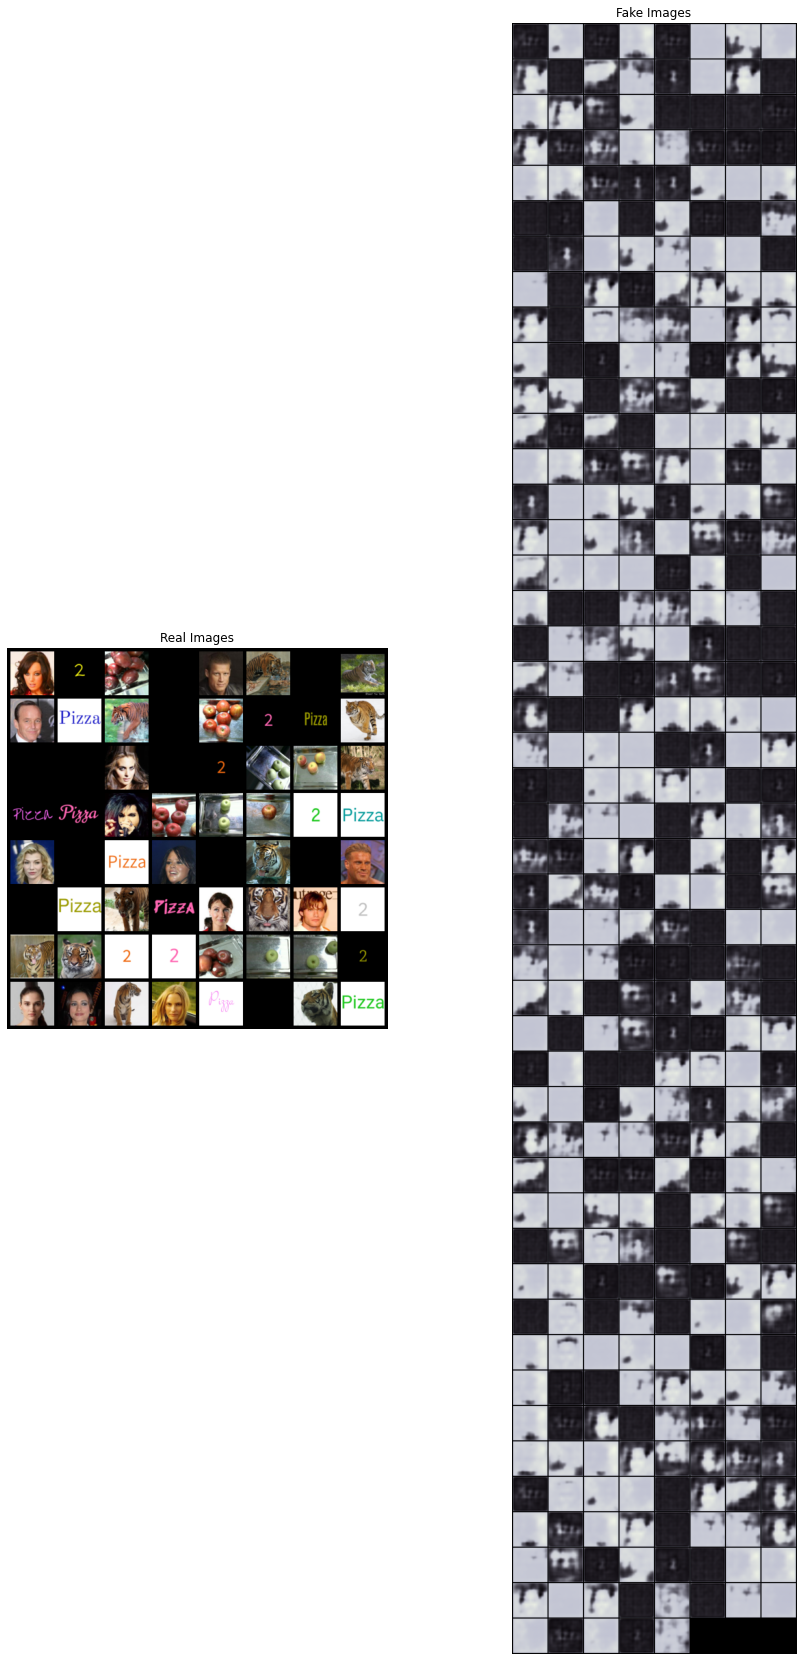

In [20]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [19]:
print(f"Time spend in second = {time.time()-start_time}")

Time spend in second = 412.28049755096436
